In [247]:
import numpy as np
from scipy.integrate import solve_ivp
from copy import deepcopy
from scipy.spatial.transform import Rotation as ScipyRot
import matplotlib.pyplot as plt
import time as systemtime

# SUPPORTING FUNCTIONS

In [248]:
def function_S(input):
    # input should be array
    # output array
    flattened_input = input.flatten()
    output = [[0,           -flattened_input[2],    flattened_input[1]],
              [flattened_input[2],  0,              -flattened_input[0]],
              [-flattened_input[1], flattened_input[0],     0]]
    return np.array(output)

In [249]:
def rodrigues_formula(quaternion):
    '''
    quaternion -> R_tilde_bar
    input: [w,x,y,z]
    output R_tile_bar (rotation matrix)
    From page6
    '''
    return np.eye(3) + 2*np.matmul(function_S(quaternion[1:]), (quaternion[0]*np.eye(3) + function_S(quaternion[1:])))


In [250]:
def function_A(omega):
    A11 = function_S(-omega)
    A12 = np.zeros((3,3))
    A21 = np.zeros((3,3))
    A22 = function_S(-omega)
    return np.vstack((np.hstack((A11, A12)), np.hstack((A21, A22))))


In [251]:
def function_Pi(input):
    '''
    Pi_x := I_3 - xx^T
    input: array
    output P_x
    '''
    return np.eye(3) - np.matmul(input, np.transpose(input))

In [252]:
def function_d(input_rot, input_p, input_z, with_noise):
    '''
    calculate d_i(t) := R^T(t)(p(t) - z_i)/|p(t)-z_i|
    '''
    norm = (input_p - input_z)/np.linalg.norm(input_p - input_z)
    dir = np.matmul(np.transpose(input_rot), norm)
    
    if with_noise:
        '''
        calculate noisy d = sign(d_{i,3}) / demon (d_{i,1}/d_{i,3} + n_{n,1}, d_{i,2}/d_{i,3} + n_{i,2}, 1).T
        demon = sqrt((d_{i,1}/d_{i,3} + n_{n,1})^2 + (d_{i,2}/d_{i,3} + n_{i,2})^2 + 1)
        '''
        dir = dir.flatten()
        n_1 = np.random.uniform(-0.005, 0.005, 1)[0]
        n_2 = np.random.uniform(-0.005, 0.005, 1)[0]
        d1_d3 = dir[0]/dir[2] + n_1
        d2_d3 = dir[1]/dir[2] + n_2
        demon = np.sqrt(d1_d3**2 + d2_d3**2 + 1)
        dir = (np.sign(dir[2])/ demon) * np.array([[d1_d3, d2_d3, 1]]).T
    return dir

In [253]:
def function_C(input_R, input_R_hat, input_p, input_z, with_noise, num_landmarks):
    for landmark_idx in range(num_landmarks):
        # S(R_hat.T x z)
        first = function_Pi(function_d(input_R, input_p, np.transpose(input_z[landmark_idx]), with_noise))
        second = function_S(np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))
        final = -np.matmul(first, second)
        C_landmark = np.hstack((final, first))
        if landmark_idx == 0:
            output_C = C_landmark
        else:
            output_C = np.vstack((output_C, C_landmark))
    return output_C

In [254]:
def add_bar(input_rot, input_p):
    return np.matmul(np.transpose(input_rot), input_p)

In [255]:
def remove_bar(input_rot, input_p_bar):
    return np.matmul(np.linalg.inv(np.transpose(input_rot)), input_p_bar)

# SIMULATION 3D - x,y,z,roll,pitch,yaw

In [256]:
def visual_plot(quaternion, figsize = (20, 4), bound_y=True):
    figure= plt.figure(figsize=figsize)
    
    plot_est_p_bar = []
    plot_act_p_bar = []
    plot_est_p = []
    plot_act_p = []
    for t, solution in zip(solt, soly):
        if quaternion:
            own_sol_R = rodrigues_formula(solution[:4])
            own_sol_est_R = rodrigues_formula(solution[4:8])
            own_sol_est_p_bar = solution[8:11]
        else:
            own_sol_R = solution[:9]
            own_sol_est_R = solution[9:18]
            own_sol_est_p_bar = solution[18:21]
        p = np.array([2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10])
        p_bar_temp = np.matmul(np.transpose(np.array(own_sol_R).reshape((3,3))), p)
        p_temp = np.matmul(np.array(own_sol_est_R).reshape((3,3)), own_sol_est_p_bar)

        plot_est_p_bar.append(own_sol_est_p_bar.tolist())
        plot_act_p_bar.append(p_bar_temp.tolist())
        plot_est_p.append(p_temp.tolist())
        plot_act_p.append(p.tolist())

    scipy_plot_est_p = []
    scipy_plot_act_p = []

    for t, rotation, p_bar_hat in zip(sol_t, sol_R, sol_est_p_bar):
        p = np.array([2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10])
        p_temp = np.matmul(np.transpose(np.array(rotation).reshape((3,3))), p)
        scipy_plot_est_p.append(p_bar_hat.tolist())
        scipy_plot_act_p.append(p_temp.tolist())
    try:
        plt.plot(solt, np.array(plot_act_p_bar)-np.array(plot_est_p_bar), label=["ox", "oy", "oz"], marker='o', markersize=0.2)
        plt.plot(sol_t, np.array(scipy_plot_act_p)-scipy_plot_est_p, label=["sx", "sy", "sz"], linestyle='dotted', marker='o', markersize=0.2)
        plt.legend(loc="upper right")
        plt.title("pose error own vs scipy")
        plt.grid()
        plt.xlim(0)
        if bound_y:
            plt.ylim(-0.5, 0.5)
        plt.minorticks_on()
        plt.show()
    except Exception as e:
        print(f"pose, {e}")

###############################################################################################################################
###############################################################################################################################
        
    figure= plt.figure(figsize=figsize)
    
    plot_err_lambda_bar = []
    plot_act_lambda_bar = []
    plot_est_lambda_bar = []
    for idx, (t, solution) in enumerate(zip(solt, soly)):
        if quaternion:
            own_sol_R = rodrigues_formula(solution[:4])
            own_sol_est_R = rodrigues_formula(solution[4:8])
        else:
            own_sol_R = solution[:9]
            own_sol_est_R = solution[9:18]
        err = np.matmul(np.linalg.inv(np.array(own_sol_est_R).reshape((3,3))), np.array(own_sol_R).reshape((3,3)))
        est = ScipyRot.from_matrix(np.array(own_sol_est_R).reshape((3,3)))
        act = ScipyRot.from_matrix(np.array(own_sol_R).reshape((3,3)))
        err = ScipyRot.from_matrix(err)
        err = err.as_quat().tolist()
        est = est.as_quat().tolist()
        act = act.as_quat().tolist()
        plot_err_lambda_bar.append(err)
        plot_est_lambda_bar.append(est)
        plot_act_lambda_bar.append(act)
    
    scipy_plot_err_lambda_bar = []
    scipy_plot_act_lambda_bar = []
    scipy_plot_est_lambda_bar = []
    for idx, (t, est_rotation, rotation) in enumerate(zip(sol_t, sol_est_R, sol_R)):
        try:
            err = np.matmul(np.linalg.inv(np.array(est_rotation).reshape((3,3))), np.array(rotation).reshape((3,3)))
        except:
            err = np.matmul(np.linalg.pinv(np.array(est_rotation).reshape((3,3))), np.array(rotation).reshape((3,3)))
        est = ScipyRot.from_matrix(np.array(est_rotation).reshape((3,3)))
        act = ScipyRot.from_matrix(np.array(rotation).reshape((3,3)))
        err = ScipyRot.from_matrix(err)
        err = err.as_quat().tolist()
        est = est.as_quat().tolist()
        act = act.as_quat().tolist()
        scipy_plot_err_lambda_bar.append(err)
        scipy_plot_est_lambda_bar.append(est)
        scipy_plot_act_lambda_bar.append(act)
    
    try:
        plt.plot(solt, np.array(plot_err_lambda_bar)[:,0:3], label=["ox", "oy", "oz"], marker='o', markersize=0.2)
        plt.plot(sol_t, np.array(scipy_plot_err_lambda_bar)[:,0:3], label=["sx", "sy", "sz"], linestyle='dotted', marker='o', markersize=0.2)
        plt.legend(loc="upper right")
        plt.title("orientation")
        plt.grid()
        plt.xlim(0)
        if bound_y:
            plt.ylim(-0.1, 0.1)
        plt.minorticks_on()
        plt.show()
    except Exception as e:
        print(f"orientation, {e}")

###############################################################################################################################
###############################################################################################################################

    figure, ax = plt.subplots(1,2, figsize=figsize)
    try:
        ax[0].plot(solt, np.array(plot_act_p), label=["actx", "acty", "actz"], marker='o', markersize=0.2)
        ax[0].legend(loc="upper right")
        ax[0].set_xlabel("own pose actual")
        ax[0].grid()
        ax[0].set_xlim(0)
        ax[0].set_ylim(-4, 11)
        ax[0].minorticks_on()

        ax[1].plot(solt, np.array(plot_est_p), label=["estx", "esty", "estz"], marker='o', markersize=0.2)
        ax[1].legend(loc="upper right")
        ax[1].set_xlabel("own pose estimate")
        ax[1].grid()
        ax[1].set_xlim(0)
        ax[1].set_ylim(-4, 11)
        ax[1].minorticks_on()
        plt.show()
    except Exception as e:
        print("self implementation, {e}")

###############################################################################################################################
###############################################################################################################################

    figure, ax = plt.subplots(1,2, figsize=figsize)
    try:
        ax[0].plot(solt, np.array(plot_act_p)-np.array(plot_est_p), label=["x", "y", "z"], marker='o', markersize=0.2)
        ax[0].legend(loc="upper right")
        ax[0].set_xlabel("own pose error")
        ax[0].grid()
        ax[0].set_xlim(0)
        ax[0].set_ylim(-0.5, 0.5)
        ax[0].minorticks_on()

        ax[1].plot(solt, np.array(plot_err_lambda_bar)[:,0:3], label=["x", "y", "z"], marker='o', markersize=0.2)
        ax[1].legend(loc="upper right")
        ax[1].set_xlabel("own orientation error")
        ax[1].grid()
        ax[1].set_xlim(0)
        ax[1].set_ylim(-0.1, 0.1)
        ax[1].minorticks_on()
        plt.show()
    except Exception as e:
        print("self implementation, {e}")

In [257]:
def data_to_csv(noise):
    import pandas as pd
    plot_est_p = []
    plot_act_p = []
    for t, rotation, p_bar_hat in zip(sol.t, sol_est_R, sol_est_p_bar):
        p = np.array([2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10])
        p_temp = np.matmul(np.linalg.inv(np.transpose(np.array(rotation).reshape((3,3)))), p_bar_hat)
        plot_est_p.append(p_temp.tolist())
        plot_act_p.append(p.tolist())

    plot_err_lambda_bar = []
    plot_act_lambda_bar = []
    plot_est_lambda_bar = []
    for idx, (t, est_rotation, rotation) in enumerate(zip(sol.t, sol_est_R, sol_R)):
        err = np.matmul(np.linalg.inv(np.array(est_rotation).reshape((3,3))), np.array(rotation).reshape((3,3)))
        est = ScipyRot.from_matrix(np.array(est_rotation).reshape((3,3)))
        act = ScipyRot.from_matrix(np.array(rotation).reshape((3,3)))
        err = ScipyRot.from_matrix(err)
        err = err.as_quat().tolist()
        est = est.as_quat().tolist()
        act = act.as_quat().tolist()
        plot_err_lambda_bar.append(err)
        plot_est_lambda_bar.append(est)
        plot_act_lambda_bar.append(act)

    # Create a DataFrame from the lists
    df = pd.DataFrame({'Actual p x': np.array(plot_act_p).T[0], 
                    'Actual p y': np.array(plot_act_p).T[1], 
                    'Actual p z': np.array(plot_act_p).T[2], 
                    
                    'Estimate P x': np.array(plot_est_p).T[0], 
                    'Estimate P y': np.array(plot_est_p).T[1], 
                    'Estimate P z': np.array(plot_est_p).T[2],

                    'Estimate P bar x': sol_est_p_bar.T[0], 
                    'Estimate P bar y': sol_est_p_bar.T[1], 
                    'Estimate P bar z': sol_est_p_bar.T[2], 
                    
                    'Error lambda bar x': np.array(plot_err_lambda_bar).T[0], 
                    'Error lambda bar y': np.array(plot_err_lambda_bar).T[1], 
                    'Error lambda bar z': np.array(plot_err_lambda_bar).T[2], 
                    'Error lambda bar w': np.array(plot_err_lambda_bar).T[3], 

                    'estimate lambda x': np.array(plot_est_lambda_bar).T[0],
                    'estimate lambda y': np.array(plot_est_lambda_bar).T[1],
                    'estimate lambda z': np.array(plot_est_lambda_bar).T[2],
                    'estimate lambda w': np.array(plot_est_lambda_bar).T[3],
                    
                    'Actual lambda x': np.array(plot_act_lambda_bar).T[0],
                    'Actual lambda y': np.array(plot_act_lambda_bar).T[1],
                    'Actual lambda z': np.array(plot_act_lambda_bar).T[2],
                    'Actual lambda w': np.array(plot_act_lambda_bar).T[3],
                    
                    'time': sol.t.tolist()})

    if noise:
        # Write the DataFrame to a text file, without the indices
        df.to_csv('/home/annika/ITRL/kth_thesis/ricatti_solution_with_noise.txt', sep='\t', index=False, header=False)
    else:
        # Write the DataFrame to a text file, without the indices
        df.to_csv('/home/annika/ITRL/kth_thesis/ricatti_solution_without_noise.txt', sep='\t', index=False, header=False)


In [258]:
def observer_equations(input_omega, input_p_bar_hat, input_R, input_v, num_landmarks, input_q, input_R_hat, input_z, input_p, with_noise, input_k, input_P, which_eq):
    if which_eq == 0:
        
        # omega
        first_upper = input_omega
        
        # -S(omega)p_bat_hat + v_bar
        first_lower = -np.matmul(function_S(input_omega), input_p_bar_hat) + add_bar(input_R, input_v)
        first_part = np.vstack((first_upper, first_lower))

        # omega_hat second part upper
        if not input_z.any() == None:
            final = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
            final2 = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
            for landmark_idx in range(num_landmarks):
                #q*S(R_hat.T z)
                first = input_q[landmark_idx]*function_S(np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))
                #Pi_d
                Pi_d = function_Pi(function_d(input_R, input_p, np.transpose(input_z[landmark_idx]), with_noise)) #TODO
                #(p_bar_hat - R_hat.T x z)
                second = input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx]))
                final += np.matmul(first, np.matmul(Pi_d, second))

                # omega_hat second part lower
                #q*Pi_d
                first = input_q[landmark_idx]*Pi_d
                #(p_bar_hat - R_hat.T x z)
                # second = input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx]))
                final2 += np.matmul(first, second)

            second_part = np.vstack((final, final2))
            #kP[]
            #full second part 
            second_part = input_k*np.matmul(input_P, second_part)

            # Final
            output_omega_hat_p_bar_hat_dot = first_part - second_part
        else:
            output_omega_hat_p_bar_hat_dot = first_part
        
    elif which_eq == 1:
        ### First part ###
        ###TODO: this observer is for lamnda and p?? 
        # omega hat
        first_upper = input_omega

        # -S(w)p_bar_hat + v_bar
        first_lower = -np.matmul(function_S(input_omega), input_p_bar_hat) + add_bar(input_R, input_v)

        # first part final
        first_part = np.vstack((first_upper, first_lower))

        if not input_z.any() == None:
            ### Second part ###
            # input_p_bar = add_bar(input_R, input_p)
            input_p_hat = np.matmul(np.linalg.inv(np.transpose(input_R_hat)), input_p_bar_hat)
            # input_p_hat = remove_bar(input_R_hat, input_p_bar_hat)
            # omega hat
            final = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
            final2 = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
            for landmark_idx in range(num_landmarks):
                Pi_d_hat = function_Pi(function_d(input_R_hat, input_p_hat, np.transpose(input_z[landmark_idx]), with_noise))
                # q |p_hat - z| S(d_i_hat) R_hat.T
                first = input_q[landmark_idx]*np.linalg.norm(input_p_hat - np.transpose(input_z[landmark_idx]))*np.matmul(function_S(function_d(input_R_hat, input_p_hat, input_z, with_noise)), np.transpose(input_R_hat))
                # |p_hat - z| Pi(d_i_hat) d_i
                second = np.linalg.norm(input_p_hat - np.transpose(input_z[landmark_idx]))*np.matmul(Pi_d_hat, function_d(input_R, input_p, np.transpose(input_z[landmark_idx]), with_noise))
                # Pi(d_i_hat) (R.T z - R_hat.T p_bar_hat)
                third = np.matmul(Pi_d_hat, (np.matmul(np.transpose(input_R), np.transpose(input_z[landmark_idx])) - np.matmul(np.transpose(input_R_hat), input_p_bar_hat)))
                final += np.matmul(first, second + third)

                # q Pi(d_i_hat) R_hat.T
                first = input_q[landmark_idx]*np.matmul(function_Pi(function_d(input_R_hat, input_p_hat, np.transpose(input_z[landmark_idx]), with_noise)), np.transpose(input_R_hat))
                # |p_hat - z| Pi(d_i_hat) d_i
                second = np.linalg.norm(input_p_hat - np.transpose(input_z[landmark_idx]))*np.matmul(function_Pi(function_d(input_R_hat, input_p_hat, np.transpose(input_z[landmark_idx]), with_noise)), function_d(input_R, input_p, np.transpose(input_z[landmark_idx]), with_noise))
                # Pi(d_i_hat) (R.T z - R_hat.T p_bar_hat)
                third = np.matmul(function_Pi(function_d(input_R_hat, input_p_hat, np.transpose(input_z[landmark_idx]), with_noise)), (np.matmul(np.transpose(input_R), np.transpose(input_z[landmark_idx])) - np.matmul(np.transpose(input_R_hat), input_p_bar_hat)))
                final2 += np.matmul(first, second + third)

            second_part = np.vstack((final, final2))
            second_part = input_k*np.matmul(input_P, second_part)

            output_omega_hat_p_bar_hat_dot = first_part + second_part
        else:
            output_omega_hat_p_bar_hat_dot = first_part

    elif which_eq == 2:
        ### First part ###
        # omega hat
        first_upper = input_omega

        # -S(w)p_bar_hat + v_bar
        first_lower = -np.matmul(function_S(input_omega), input_p_bar_hat) + add_bar(input_R, input_v)
        # first part final
        first_part = np.vstack((first_upper, first_lower))

        if not input_z.any() == None:
            ### Second part ###
            # omega hat
            final = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
            final2 = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
            for landmark_idx in range(num_landmarks):
                d_bar_hat = (input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))/ np.linalg.norm(input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))
                Pi_d_bar_hat = function_Pi(d_bar_hat)
                # q S(R_hat.T z) Pi_d_bar_hat 
                first = input_q[landmark_idx]*np.matmul(function_S(np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx]))), Pi_d_bar_hat)
                # |p_bar_hat - R_hat.T z| di
                second = np.linalg.norm(input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))*function_d(input_R, input_p, np.transpose(input_z[landmark_idx]), with_noise)
                final += np.matmul(first, second)

                # q Pi_d_bar_hat
                first = input_q[landmark_idx]*Pi_d_bar_hat
                # |p_bar_hat - R_hat.T z| di
                #second 
                final2 += np.matmul(first, second)

            second_part = np.vstack((final, final2))
            second_part = input_k*np.matmul(input_P, second_part)

            output_omega_hat_p_bar_hat_dot = first_part + second_part
        else:
            output_omega_hat_p_bar_hat_dot = first_part

    return output_omega_hat_p_bar_hat_dot

In [259]:
def dynamics(t, y, input_k, input_z, input_q, input_Q, input_V, with_noise, num_landmarks, which_eq, quaternion, which_omega):
    # pose
    input_p = np.transpose(np.array([[2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10]]))

    ####################################
    ########### Measurements ###########
    if with_noise:
        b_v = np.random.normal(0, 0.1, 1)
        b_omega = np.random.normal(0, 0.01, 1)
        # velocity
        input_v = np.transpose(np.array([[-np.sin(0.4*t), np.cos(0.4*t), 0]])) + b_v
        # angular velocity
        if which_omega == "z":
            input_omega = np.transpose(np.array([[0 ,0 , 0.6*t]])) + b_omega
        elif which_omega == "full":
            input_omega = np.transpose(np.array([[0.1*np.sin(t), 0.4*np.cos(2*t), 0.6*t]])) + b_omega
    else:
        # velocity
        input_v = np.transpose(np.array([[-np.sin(0.4*t), np.cos(0.4*t), 0]]))
        # angular velocity
        if which_omega == "z":
            input_omega = np.transpose(np.array([[0, 0, 0.6*t]]))
        elif which_omega == "full":
            input_omega = np.transpose(np.array([[0.1*np.sin(t), 0.4*np.cos(2*t), 0.6*t]]))
    ########### Measurements ###########
    ####################################

    if quaternion:
        ####################################
        ############ Quaternion ############
        qua_flat, qua_hat_flat, p_bar_hat_flat, input_P_flat = np.split(y, [4, 8, 11])
        qua_flat = qua_flat/np.linalg.norm(qua_flat)
        qua_hat_flat = qua_hat_flat/np.linalg.norm(qua_hat_flat)
        input_R = rodrigues_formula(qua_flat)
        input_R_hat = rodrigues_formula(qua_hat_flat)
      ############ Quaternion ############
      ####################################
    else:
        ####################################
        ######### Rotation Matrix ##########
        Rot_flat, Rot_hat_flat, p_bar_hat_flat, input_P_flat = np.split(y, [9, 18, 21])
        input_R = Rot_flat.reshape((3,3))
        input_R_hat = Rot_hat_flat.reshape((3,3))
        ######### Rotation Matrix ##########
        ####################################
    
    input_p_bar_hat = p_bar_hat_flat.reshape((3,1))
    input_P = input_P_flat.reshape((6,6))

    input_A = function_A(input_omega)
    if not input_z.any() == None:
        input_C = function_C(input_R, input_R_hat, input_p, input_z, with_noise, num_landmarks)
    ####################################

    ####################################
    ############# Observer #############
    output_omega_hat_p_bar_hat_dot = observer_equations(input_omega, input_p_bar_hat, input_R, input_v, num_landmarks, input_q, input_R_hat, input_z, input_p, with_noise, input_k, input_P, which_eq)
    # output_omega_hat_p_bar_hat_dot[:2,:] = 0.0
    ############# Observer #############
    ####################################
    
    if not input_z.any() == None:
        output_P_dot = np.matmul(input_A, input_P) + np.matmul(input_P, np.transpose(input_A)) - np.matmul(input_P, np.matmul(np.transpose(input_C), np.matmul(input_Q, np.matmul(input_C, input_P)))) + input_V
    else:
        output_P_dot = np.matmul(input_A, input_P) + np.matmul(input_P, np.transpose(input_A)) + input_V

    p_bar_hat_dot = output_omega_hat_p_bar_hat_dot[3:]

    if quaternion:
        ####################################
        ############ Quaternion ############
        omega_hat = output_omega_hat_p_bar_hat_dot[0:3].flatten()
        omega_hat_4x4 = np.array([[0, -omega_hat[0], -omega_hat[1], -omega_hat[2]],
                                  [omega_hat[0], 0, omega_hat[2], -omega_hat[1]],
                                  [omega_hat[1], -omega_hat[2], 0, omega_hat[0]],
                                  [omega_hat[2], omega_hat[1], -omega_hat[0], 0]])

        output_qua_hat_flat = 0.5*np.matmul(omega_hat_4x4, qua_hat_flat)
        input_omega = input_omega.flatten()
        omega_4x4 = np.array([[0, -input_omega[0], -input_omega[1], -input_omega[2]],
                                  [input_omega[0], 0, input_omega[2], -input_omega[1]],
                                  [input_omega[1], -input_omega[2], 0, input_omega[0]],
                                  [input_omega[2], input_omega[1], -input_omega[0], 0]])
        output_qua_flat = 0.5*np.matmul(omega_4x4, qua_flat)
        return np.concatenate((output_qua_flat, output_qua_hat_flat, p_bar_hat_dot.flatten(), output_P_dot.flatten()))
        ########### Quaternion ############
        ####################################
    else:
        ####################################
        ######### Rotation Matrix ##########
        omega_hat = output_omega_hat_p_bar_hat_dot[0:3]
        output_R_hat_dot = np.matmul(input_R_hat, function_S(omega_hat))
        output_R = np.matmul(input_R, function_S(input_omega))

        # (Rot.flatten(), Rot_hat.flatten(), p_bar_hat.flatten(), P_ricatti.flatten())
        return np.concatenate((output_R.flatten(), output_R_hat_dot.flatten(), p_bar_hat_dot.flatten(), output_P_dot.flatten()))
        ######### Rotation Matrix ##########
        ####################################

In [260]:
def rk45_step(t, y, dt, args, tol, adaptive):
    a2, a3, a4, a5, a6 = 1/5, 3/10, 4/5, 8/9, 1
    b21 = 1/5
    b31, b32 = 3/40, 9/40
    b41, b42, b43 = 44/45, -56/15, 32/9
    b51, b52, b53, b54 = 19372/6561, -25360/2187, 64448/6561, -212/729
    b61, b62, b63, b64, b65 = 9017/3168, -355/33, 46732/5247, 49/176, -5103/18656
    c1, c2, c3, c4, c5, c6 = 35/384, 0, 500/1113, 125/192, -2187/6784, 11/84

    c1_4, c3_4, c4_4, c5_4, c6_4 = 5179/57600, 7571/16695, 393/640, -92097/339200, 187/2100
    # Runge-Kutta stages
    k1 = dynamics(t, y, *args)
    k2 = dynamics(t + a2*dt, y + dt*b21*k1, *args)
    k3 = dynamics(t + a3*dt, y + dt*(b31*k1 + b32*k2), *args)
    k4 = dynamics(t + a4*dt, y + dt*(b41*k1 + b42*k2 + b43*k3), *args)
    k5 = dynamics(t + a5*dt, y + dt*(b51*k1 + b52*k2 + b53*k3 + b54*k4), *args)
    k6 = dynamics(t + a6*dt, y + dt*(b61*k1 + b62*k2 + b63*k3 + b64*k4 + b65*k5), *args)

    # Update step
    y_next = y + dt*(c1*k1 + c2*k2 + c3*k3 + c4*k4 + c5*k5 + c6*k6)

    if adaptive:
        y_next_4 = y + dt * (c1_4*k1 + c3_4*k3 + c4_4*k4 + c5_4*k5 + c6_4*k6)

        error = np.abs(y_next - y_next_4)
        error_norm = np.linalg.norm(error)
        safety_factor = 0.9
        min_scale_factor = 0.2
        max_scale_factor = 40.0
        if error_norm <= tol:
            success = True
            t = t+dt
            dt = dt * min(max_scale_factor, max(min_scale_factor, safety_factor * (tol / error_norm)**0.25))
        else:
            success = False
            dt = dt * max(min_scale_factor, safety_factor * (tol / error_norm)**0.25)
    else: 
        if np.isnan(y_next).any():
            success = False
        else:
            success = True
    return y_next, t, dt, success

In [261]:
### Parameter
######################################################
##################### Parameters #####################

use_adaptive = True
quaternion = True
noise = False
which_eq = 2
with_image_hz_sim = False
randomize_image_input = False
which_omega = "full" # "z" or "full"
time = (0, 40)
stepsize = 0.1
times = np.arange(*time, stepsize)

image_hz = 20
image_time = np.arange(time[0], time[1]+1/image_hz, 1/image_hz)

tol = 1e-2 * 3 
# tol = 1e-2 * 5
# tol = 0.05

plot_graph = True
save_graph = False
save_as_csv = False
# threshold_image = 0.0001
##################### Parameters #####################
######################################################

In [270]:
### Run solver
print("\n Parameters \n",
"use_adaptive           | ", use_adaptive,          "\n",
"quaternion             | ", quaternion,            "\n",
"noise                  | ", noise,                 "\n",
"which_eq               | ", which_eq,              "\n",
"which_omega            | ", which_omega,            "\n",
"with_image_hz_sim      | ", with_image_hz_sim,     "\n",
"randomize_image_input  | ", randomize_image_input, "\n",
"time                   | ", time,                  "\n",
"stepsize               | ", stepsize,              "\n",
"image_hz               | ", image_hz,              "\n",
"tol                    | ", tol,                   "\n")

######################################################
################### initialization ###################
# landmarks
# z_appear = np.array([[[2.5, 2.5, 0]], [[5, 0, 0]], [[0, 0, 0]],[[2.5,-2.5,0]]])
z_appear = np.array([[[2.5, 2.5, 0]], [[5, 0, 0]], [[0, 0, 0]]])
l = len(z_appear)
k = 0.1
V = np.diag(np.hstack([np.diag(0.1*np.eye(3)), np.diag(np.eye(3))]))
q = [10] * l
Q = np.diag(np.hstack([np.diag(q[i]*np.eye(3)) for i in range(l)]))

Rot = np.eye(3)
## R_hat = R x R_tilde_bar
Lambda_bar_0 = np.array([np.sqrt(2)/2, np.sqrt(2)/2, 0, 0]).T  # quaternion: w, x, y, z
Lambda_0 = np.array([1, 0, 0, 0]).T  # quaternion: w, x, y, z

Rot_hat = np.matmul(Rot, rodrigues_formula(Lambda_bar_0)) 
p_hat = np.array([[-2, 4, 3]], dtype=np.float64).T

# p_hat = np.array([[1, 4, 7]], dtype=np.float64).T
# p = np.array([[2.5, 0, 10]], dtype=np.float64).T

p_bar_hat = add_bar(Rot_hat, p_hat)
P_ricatti = np.diag(np.hstack([np.diag(np.eye(3)), np.diag(100*np.eye(3))]))
if quaternion:
    initial_state = np.concatenate((Lambda_0.flatten(), Lambda_bar_0.flatten(), p_bar_hat.flatten(), P_ricatti.flatten()))
else:
    initial_state = np.concatenate((Rot.flatten(), Rot_hat.flatten(), p_bar_hat.flatten(), P_ricatti.flatten()))

soly = []
solt = []
caltime = []
soly.append(initial_state)
dt = stepsize
current_time = 0
start_time = systemtime.time()
run_time = systemtime.time()
################### initialization ###################
######################################################

######################################################
####################### Solver #######################
i = 0
solimage = []
solnumlandmark = []
show_measurement = False
while current_time <= time[1]:
    # print(f"Simulation time: {current_time} Run time: {systemtime.time()-run_time}", end='\r', flush=True) 
    simulation_time_str = f"Simulation time: {current_time}"
    print(f"{simulation_time_str}{' ' * (40 - len(simulation_time_str))}Run time: {systemtime.time()-run_time}", end='\r', flush=True)
    if with_image_hz_sim:
        # show_measurement = any(abs(current_time - t)/(t+1e-10) <= threshold_image for t in image_time)
        show_measurement = np.round(current_time, decimals=2) == np.round(image_time[min(i, len(image_time)-1)], decimals=2)
        if show_measurement:
            if randomize_image_input:
                l = np.random.rand(len(z_appear),1)
                l = l/np.linalg.norm(l)
                l = np.rint(l).astype(int)
                z = z_appear[l[:, 0] == 1]
                l = np.sum(l)
                q = [10] * l
                Q = np.diag(np.hstack([np.diag(q[i]*np.eye(3)) for i in range(l)]))
            else:
                z = z_appear
        else:
            z = np.array([None])
    else:
        z = z_appear
        # q = [10] * l
        # Q = np.diag(np.hstack([np.diag(q[i]*np.eye(3)) for i in range(l)]))

    args = (k, z, q, Q, V, noise, l, which_eq, quaternion, which_omega)
    y_next, next_time, new_dt, success = rk45_step(current_time, soly[-1], dt, args, tol, use_adaptive)
    if use_adaptive:
        if success:
            # if show_measurement:
                # print(current_time, image_time[i])
            soly.append(y_next)
            solt.append(current_time)
            solimage.append([current_time, show_measurement])
            solnumlandmark.append(l)
            # solnumlandmark.append(show_measurement)
            end_time = systemtime.time()
            caltime.append(end_time - start_time)
            start_time = end_time
            if next_time >= time[1]:
                break
            if with_image_hz_sim:
                if show_measurement:
                    i += 1
                # if current_time >= image_time[i]:
                    # i += 1
                if next_time + new_dt < image_time[min(i, len(image_time)-1)]:
                    dt = new_dt if new_dt != 0 else min(stepsize, 1/image_hz)
                else:
                    dt = abs(image_time[min(i, len(image_time)-1)] - next_time)
            else:
                dt = new_dt
            current_time = next_time
        else:
            dt = new_dt
    else:
        if success:
            soly.append(y_next)
            solt.append(current_time)
            end_time = systemtime.time()
            caltime.append(end_time - start_time)
            start_time = end_time
            current_time += dt
        else:
            print(current_time, len(soly))
            break

####################### Solver #######################
######################################################


 Parameters 
 use_adaptive           |  True 
 quaternion             |  True 
 noise                  |  False 
 which_eq               |  2 
 which_omega            |  full 
 with_image_hz_sim      |  False 
 randomize_image_input  |  False 
 time                   |  (0, 40) 
 stepsize               |  0.1 
 image_hz               |  20 
 tol                    |  0.03 



In [263]:
### Scipy simulation

# Rtol=1e-9 #with noise, 1e-6
# Atol=1e-9 #with noise, 1e-6
# z = z_appear
# sol = solve_ivp(dynamics, time, initial_state, args=(k, z, q, Q, V, noise, l, which_eq, quaternion), t_eval=np.linspace(*(time), 200), method="RK45", rtol=Rtol, atol=Atol)
# scipy_solution = np.transpose(np.array(sol.y))
# sol_t = sol.t
# import pandas as pd
# df = pd.DataFrame(np.vstack((sol.y, sol.t)).flatten())
# df.to_csv('/home/annika/ITRL/kth_thesis/simulated_result/ricatti_solution_for_100s_step_1e-3_rtol_atol_1e-9_qua_eq2.txt', sep='\t', index=False, header=False)

import pandas as pd
scipy_solution = pd.read_csv('/home/annika/ITRL/kth_thesis/simulated_result/ricatti_solution_for_100s_step_1e-3_rtol_atol_1e-9_eq2.txt', header=None)
scipy_solution = np.transpose(scipy_solution.to_numpy().reshape((58,-1)))
sol_t = scipy_solution[:,57]

sol_R = scipy_solution[:,:9]
sol_est_R = scipy_solution[:,9:18]
sol_est_p_bar = scipy_solution[:,18:21]
sol_P_ricatti = scipy_solution[:,21:57]


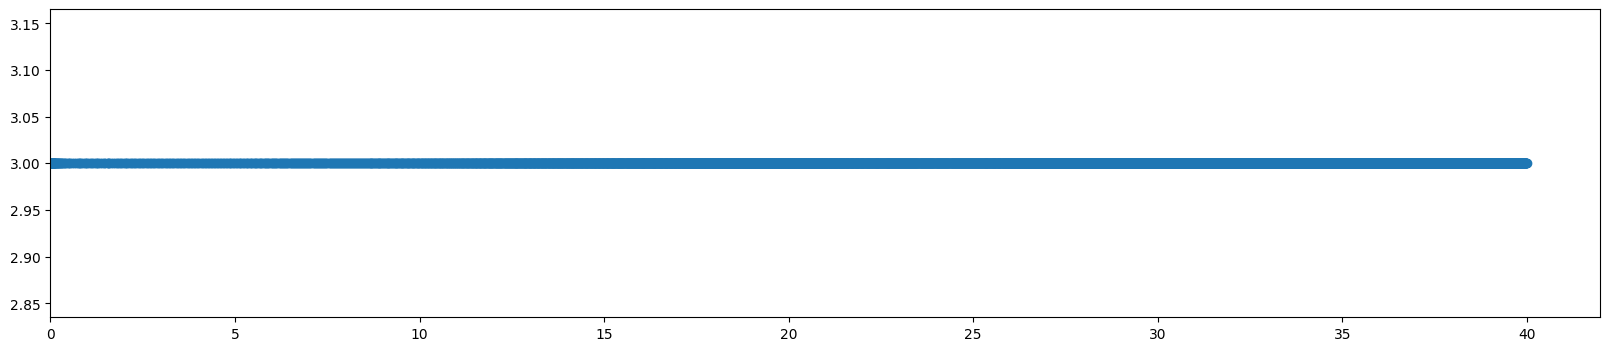

In [264]:
figure = plt.subplots(figsize=(20,4))
plt.scatter(solt, solnumlandmark)
plt.xlim(0)
plt.show()

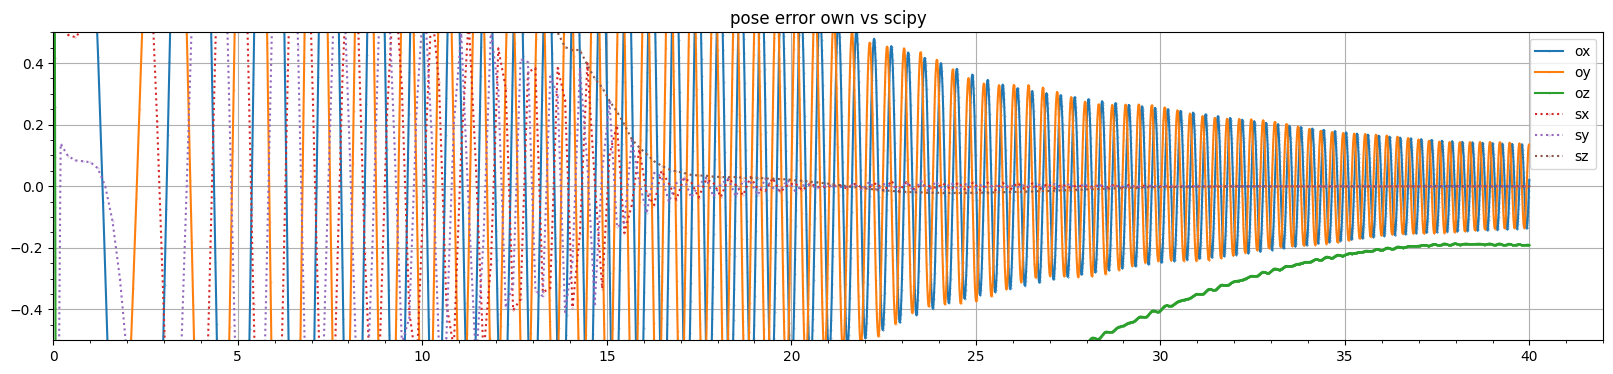

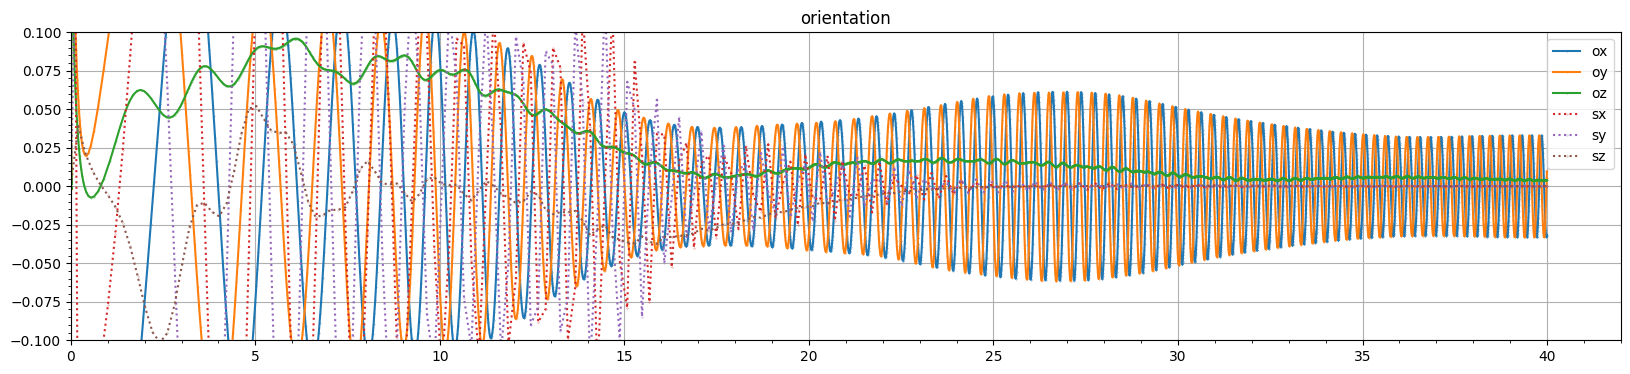

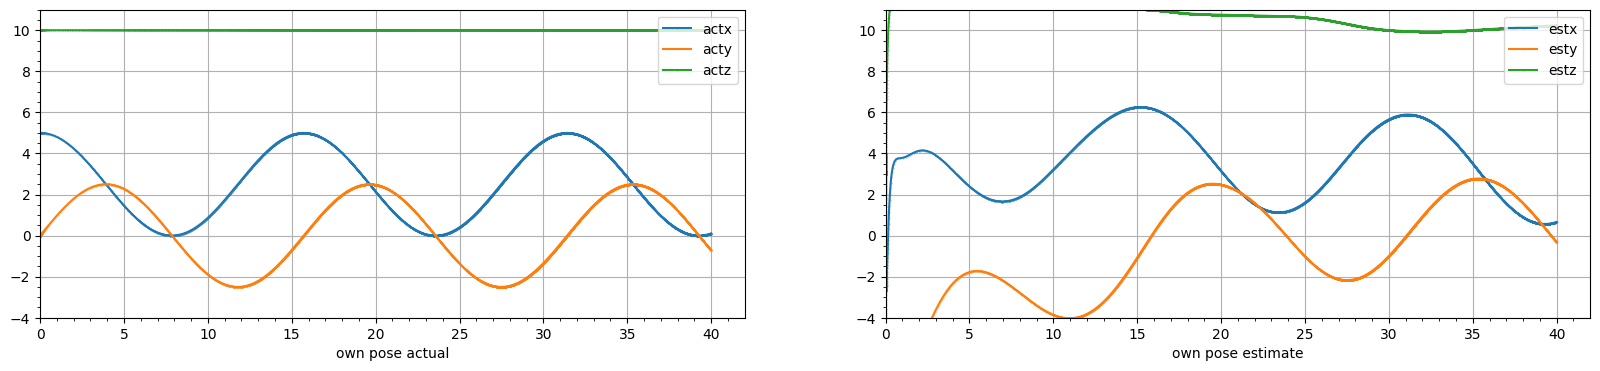

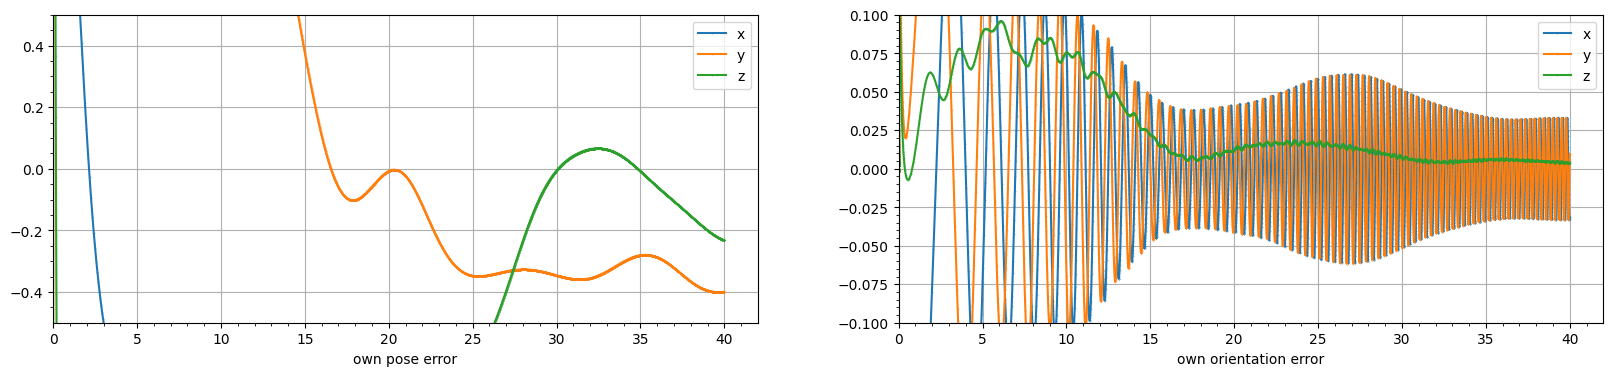

In [271]:
### Plot
lim = 10
limo = 1
visual_plot(quaternion, bound_y=True)  

In [266]:
# import pandas as pd
# df = pd.DataFrame(np.array(soly))
# df.to_csv('/home/annika/ITRL/kth_thesis/ricatti_solution_own_rk45_sim5_without_noise.txt', sep='\t', index=False, header=False)

[2838. 1737.  152.   88.  101.   30.   65.   11.    4.    7.]
[1.93979876e-06 6.55281781e-03 1.31036958e-02 1.96545738e-02
 2.62054519e-02 3.27563299e-02 3.93072079e-02 4.58580859e-02
 5.24089639e-02 5.89598419e-02 6.55107199e-02]


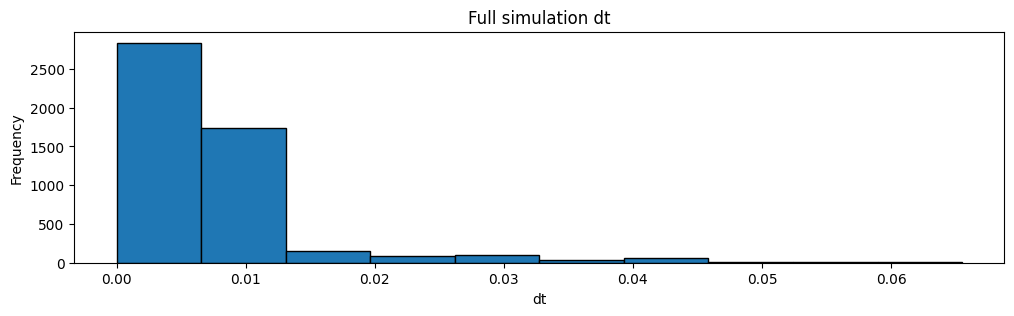

[ 230.   10.    5.    3.    3.    2. 1221.  723.  503.  138.]
[1.93979876e-06 6.56253675e-04 1.31056755e-03 1.96488143e-03
 2.61919530e-03 3.27350918e-03 3.92782305e-03 4.58213693e-03
 5.23645081e-03 5.89076468e-03 6.54507856e-03]


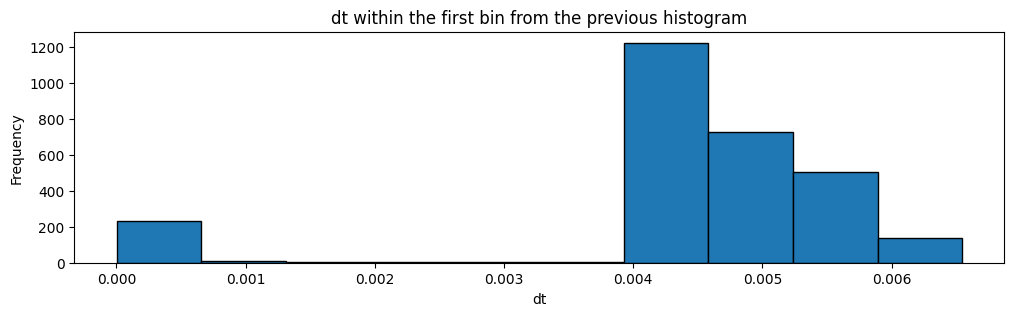

In [267]:
dttemp = []
for idxtemp, ttemp in enumerate(solt):
    if idxtemp < len(solt)-1:
        dttemp.append(solt[idxtemp+1] - solt[idxtemp])

num_bins = 10
figure= plt.figure(figsize=(12,3))
counts, bins, patches = plt.hist(dttemp, bins=num_bins, edgecolor='black')
plt.xlabel('dt')
plt.ylabel('Frequency')
plt.title('Full simulation dt')
print(counts)
print(bins)
# Show plot
plt.show()
bin1 = []
for ttemp in dttemp:
    if ttemp < bins[1]:
        bin1.append(ttemp)

num_bins = 10
figure= plt.figure(figsize=(12,3))
counts2, bins2, patches = plt.hist(bin1, bins=num_bins, edgecolor='black')
plt.xlabel('dt')
plt.ylabel('Frequency')
plt.title('dt within the first bin from the previous histogram')
print(counts2)
print(bins2)
# Show plot
plt.show()

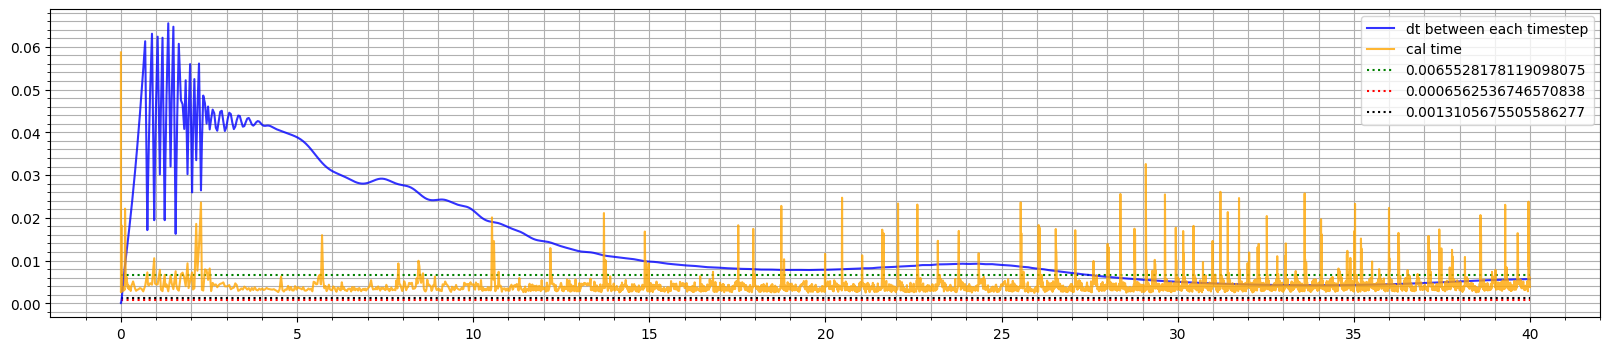

lowest dt:  1.939798755539832e-06


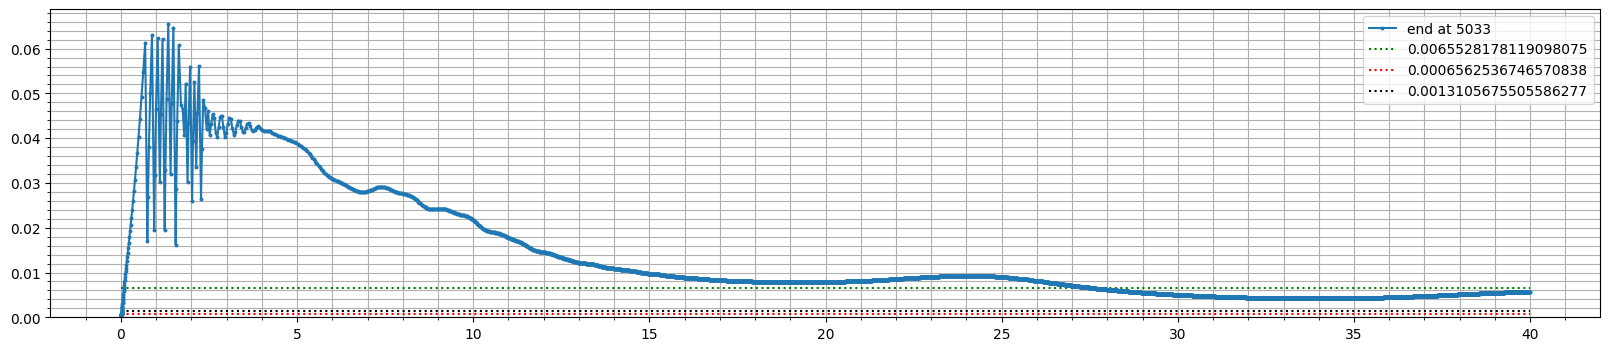

In [268]:
figsize = (20,4)
figure = plt.figure(figsize=figsize)
plt.plot(solt[:-1], dttemp, color="blue", alpha=0.8, label="dt between each timestep")
# plt.plot(solt, np.array(plot_act_p)-np.array(plot_est_p), label=["x", "y", "z"], marker='o', markersize=0.2)
plt.hlines(y=bins[1], xmin=0, xmax=time[1], color='green', linestyles='dotted', label=bins[1])
plt.hlines(y=bins2[1], xmin=0, xmax=time[1], color='red', linestyles='dotted', label=bins2[1])
plt.hlines(y=bins2[2], xmin=0, xmax=time[1], color='black', linestyles='dotted', label=bins2[2])
plt.plot(solt, caltime, color="orange", alpha=0.8, label="cal time")
plt.minorticks_on()
# plt.ylim(0, bins[1])
plt.legend()
plt.grid(which='both')
plt.show()

figure = plt.figure(figsize=figsize)
end = len(solt)-1
print("lowest dt: ", min(dttemp))
plt.plot(solt[:end], dttemp[:end], label="end at " + str(end), marker='o', markersize=1.8)
plt.hlines(y=bins[1], xmin=0, xmax=solt[end], color='green', linestyles='dotted', label=bins[1])
plt.hlines(y=bins2[1], xmin=0, xmax=solt[end], color='red', linestyles='dotted', label=bins2[1])
plt.hlines(y=bins2[2], xmin=0, xmax=solt[end], color='black', linestyles='dotted', label=bins2[2])
plt.minorticks_on()
plt.ylim(0)
plt.legend()
plt.grid(which='both')
plt.show()

